In [21]:
# CaLチャネルの動態（Lytton and Sejnowski 1991 の実装）
function CaLKineticsW(V)
    alpham = 1.6 / (exp(-0.072 * (V - 5)) + 1)
    denom = exp((V + 8.69)/5.36) - 1
    betam = 0.02 * (V + 8.69) / denom
    if abs(V + 8.69) < eps(Float64)
        betam = 0.02 * 5.36 / exp((V + 8.69)/5.36)
    end
    moo = alpham / (alpham + betam)
    taum = 1e-3 / (alpham + betam)   # 単位 ms -> s に変換
    return moo, taum
end

CaLKineticsW (generic function with 1 method)

In [22]:
using Plots

In [38]:
V = -100:0.1:130
# ブロードキャストを使ってベクトル入力に対応
res = CaLKineticsW.(V)
# CaLの活性化関数 moo をプロット

2301-element Vector{Tuple{Float64, Float64}}:
 (0.0004559121266960986, 0.0005473354769104992)
 (0.0004597065255782038, 0.000547933479214502)
 (0.0004635330336122024, 0.0005485327765936377)
 (0.00046739192786245765, 0.0005491333731645529)
 (0.0004712834878387744, 0.0005497352730606594)
 (0.00047520799551854667, 0.0005503384804322143)
 (0.0004791657353691116, 0.0005509429994464007)
 (0.00048315699437031503, 0.0005515488342874085)
 (0.0004871820620372783, 0.0005521559891565156)
 (0.0004912412304433914, 0.0005527644682721698)
 (0.0004953347942435054, 0.0005533742758700707)
 (0.0004994630506973554, 0.0005539854162032525)
 (0.0005036262996931912, 0.0005545978935421673)
 ⋮
 (0.9999999999877731, 0.00062508348832796)
 (0.9999999999879905, 0.0006250828893709129)
 (0.9999999999882039, 0.0006250822947108673)
 (0.9999999999884136, 0.0006250817043169959)
 (0.9999999999886194, 0.0006250811181586925)
 (0.9999999999888218, 0.0006250805362055709)
 (0.9999999999890204, 0.0006250799584274622)
 (0.99999999

In [40]:
res = hcat(first.(res), last.(res))

2301×2 Matrix{Float64}:
 0.000455912  0.000547335
 0.000459707  0.000547933
 0.000463533  0.000548533
 0.000467392  0.000549133
 0.000471283  0.000549735
 0.000475208  0.000550338
 0.000479166  0.000550943
 0.000483157  0.000551549
 0.000487182  0.000552156
 0.000491241  0.000552764
 0.000495335  0.000553374
 0.000499463  0.000553985
 0.000503626  0.000554598
 ⋮            
 1.0          0.000625083
 1.0          0.000625083
 1.0          0.000625082
 1.0          0.000625082
 1.0          0.000625081
 1.0          0.000625081
 1.0          0.00062508
 1.0          0.000625079
 1.0          0.000625079
 1.0          0.000625078
 1.0          0.000625078
 1.0          0.000625077

In [41]:
moo = res[:, 1]
taum = res[:, 2]

2301-element Vector{Float64}:
 0.0005473354769104992
 0.000547933479214502
 0.0005485327765936377
 0.0005491333731645529
 0.0005497352730606594
 0.0005503384804322143
 0.0005509429994464007
 0.0005515488342874085
 0.0005521559891565156
 0.0005527644682721698
 0.0005533742758700707
 0.0005539854162032525
 0.0005545978935421673
 ⋮
 0.00062508348832796
 0.0006250828893709129
 0.0006250822947108673
 0.0006250817043169959
 0.0006250811181586925
 0.0006250805362055709
 0.0006250799584274622
 0.0006250793847944147
 0.0006250788152766907
 0.0006250782498447667
 0.0006250776884693302
 0.0006250771311212798

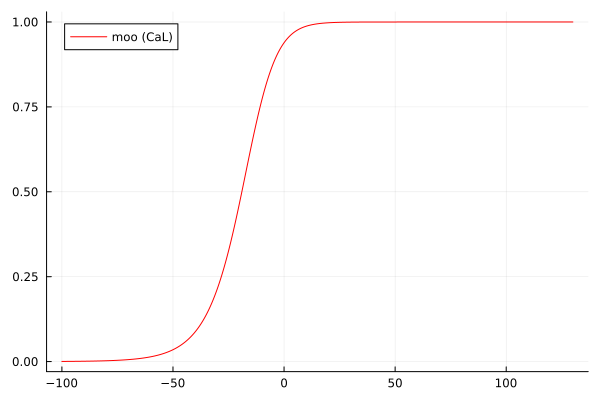

In [43]:
plot(V, moo, color="red", label="moo (CaL)")

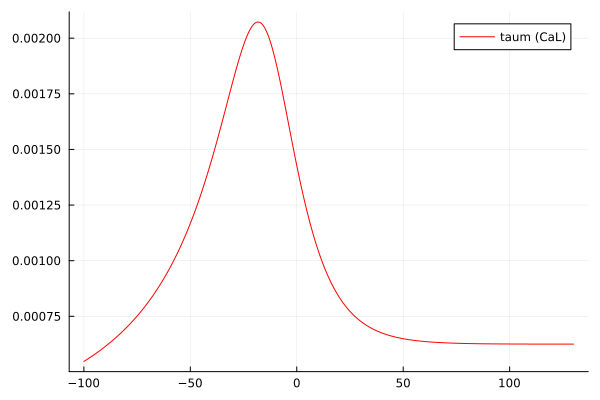

In [44]:
# 時定数 taum のプロット
plot(V, taum, color="red", label="taum (CaL)")

In [45]:
# Ca²⁺平衡電位を固定して、ICa = (moo²)*(V - ECa) を計算・プロット
ECa = 135
ICa = (moo .^ 2) .* (V .- ECa)

2301-element Vector{Float64}:
 -4.884612880811147e-5
 -4.964143806094226e-5
 -5.0449802639036877e-5
 -5.127143878001213e-5
 -5.2106566338364055e-5
 -5.295540884661506e-5
 -5.381819357750696e-5
 -5.4695151607258544e-5
 -5.558651787990349e-5
 -5.6492531272732445e-5
 -5.741343466285187e-5
 -5.834947499488552e-5
 -5.9300903349833e-5
  ⋮
 -6.099999999850832
 -5.999999999855886
 -5.899999999860806
 -5.799999999865598
 -5.699999999870262
 -5.599999999874804
 -5.499999999879225
 -5.399999999883529
 -5.299999999887716
 -5.199999999891795
 -5.099999999895761
 -4.9999999998996225

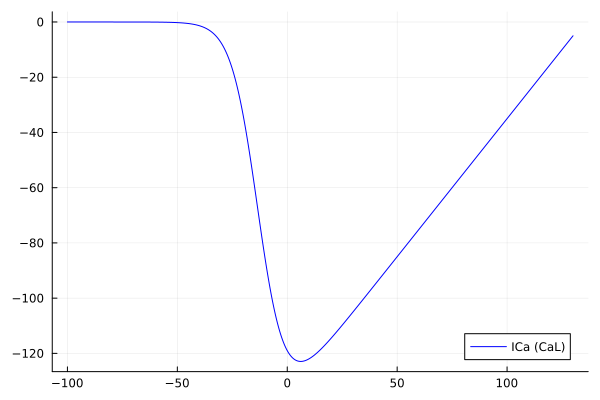

In [46]:
plot(V, ICa, color="blue", label="ICa (CaL)")

In [24]:
V 

-100.0:0.1:130.0

In [2]:
function IhKinetics(V)
    αm = (6.43 * (V + 154)) / (exp((V + 154) / 11.9) - 1)
    βm = 193 * exp(V / 33.1)
    if isnan(αm)
        # 発散（ゼロ除算）の場合の補正
        αm = 6.43 / ((1/11.9)*exp((V+154)/11.9))
    end
    moo = αm / (αm + βm)
    τm = 1 / (αm + βm)
    return moo, τm
end

IhKinetics (generic function with 1 method)

In [3]:
function ImKinetics(V)
    T_adj = 2.3^((34-21)/10)
    αm = 0.0033 * exp(0.1 * (V + 35))
    βm = 0.0033 * exp(-0.1 * (V + 35))
    moo = αm / (αm + βm)
    τm = 1e-3 / (T_adj * (αm + βm))
    return moo, τm
end

ImKinetics (generic function with 1 method)

In [4]:
function KKinetics(V)
    if V == -55
        αm = 0.1
    else
        αm = 0.01*(V + 55) / (1 - exp(-(V + 55)/10))
    end
    βm = 0.125 * exp(-(V + 65)/80)
    moo = αm / (αm + βm)
    τm = 1e-3 / (αm + βm)
    return moo, τm
end

KKinetics (generic function with 1 method)

In [5]:
function KslowKinetics(V)
    T_adj = 2.3^((34-21)/10)
    moo = 1 / (1 + exp(-(V + 11)/12))
    hoo = 1 / (1 + exp((V + 64)/11))
    if V < -50
        τm = 1e-3 * (1.25 + 175.03 * exp(0.026 * (V + 10))) / T_adj
    else
        τm = 1e-3 * (1.25 + 13 * exp(-0.026 * (V + 10))) / T_adj
    end
    τh = 1e-3 * (360 + (1010 + 24*(V+65)) * exp(-((V+85)/48)^2)) / T_adj
    return moo, τm, hoo, τh
end

KslowKinetics (generic function with 1 method)

In [6]:
function NaKinetics(V)
    if V == -40
        αm = 1
    else
        αm = (V + 40) / (10 * (1 - exp(-(V + 40)/10)))
    end
    βm = 4 * exp(-(V + 65)/18)
    moo = αm / (αm + βm)
    τm = 1e-3 / (αm + βm)
    
    αh = 0.07 * exp(-(V + 65)/20)
    βh = 1 / (1 + exp(-(V + 35)/10))
    hoo = αh / (αh + βh)
    τh = 1e-3 / (αh + βh)
    return moo, τm, hoo, τh
end

NaKinetics (generic function with 1 method)

In [7]:
function NapKinetics(V)
    αm = 0.182 * (V + 38) / (1 - exp(-(V + 38)/6))
    βm = -0.124 * (V + 38) / (1 - exp((V + 38)/6))
    if abs(V + 38) < eps(Float64)
        αm = 0.182 * 6 / exp(-(V + 38)/6)
        βm = 0.124 * 6 / exp((V + 38)/6)
    end
    T_adj = 2.3^((34-21)/10)
    # MATLABの実装では一部（下の行）のコードが上書きされているため，
    # ここでは最終版としてシグモイド型の活性化関数を使用する例です
    moo = 1 / (1 + exp(-(V + 52.6)/4.6))
    τm = 1e-3 * 6 / (T_adj * (αm + βm))
    
    αh = -2.88e-6 * (V + 17) / (1 - exp((V + 17)/4.63))
    βh  = 6.94e-6 * (V + 64.4) / (1 - exp(-(V + 64.4)/2.63))
    if abs(V + 17) < eps(Float64)
        αh = 2.88e-6 * 4.63 / exp((V + 17)/4.63)
    end
    if abs(V + 64.4) < eps(Float64)
        βh = 6.94e-6 * 2.63 / exp(-(V + 64.4)/2.63)
    end
    hoo = 1 / (1 + exp((V + 48.8)/10))
    τh = 1e-3 / (T_adj * (αh + βh))
    return moo, τm, hoo, τh
end

NapKinetics (generic function with 1 method)

In [20]:
NapKinetics(60)

(0.9999999999765994, 0.00011392198432056308, 1.8830760452806073e-5, 0.39225993830007905)

In [11]:
# イオンチャネルの動態関数（例としてNaKineticsを示す）
function NaKinetics(V)
    if V == -40
        αm = 1
    else
        αm = (V + 40) / (10 * (1 - exp(-(V + 40)/10)))
    end
    βm = 4 * exp(-(V + 65)/18)
    αh = 0.07 * exp(-(V + 65)/20)
    βh = 1 / (1 + exp(-(V + 35)/10))
    m = αm / (αm + βm)
    h = αh / (αh + βh)
    τ_m = 1e-3 / (αm + βm)
    τ_h = 1e-3 / (αh + βh)
    return m, τ_m, h, τ_h
end



# 2コンパートメントモデルのEuler法による実装
function two_compartment_euler!(u, p, dt)
    Vs, Vd = u[1], u[2]  # 細胞体（Vs）と樹状突起（Vd）の膜電位

    # Na+電流の計算（Hodgkin-Huxley形式）
    m, τ_m, h, τ_h = NaKinetics(Vs)
    INa = p.gNa * m^3 * h * (Vs - p.ENa)
    
    # 他のイオン電流も同様に計算（簡略化のため、IKdr, ICaL などは省略）

    # 微分方程式の右辺の計算（Euler法）
    dVs = (-INa + (Vd - Vs) / p.RT) / p.Cms
    dVd = (INa + (Vs - Vd) / p.RT) / p.Cd

    # Euler法で次の時間ステップの膜電位を計算
    u[1] += dVs * dt
    u[2] += dVd * dt
end

# パラメータ設定
struct ModelParams
    Cms::Float64  # 細胞体の膜容量 (F)
    Cd::Float64   # 樹状突起の膜容量 (F)
    RT::Float64   # 伝達抵抗 (Ω)
    gNa::Float64  # Na+最大伝導度 (S)
    ENa::Float64  # Na+平衡電位 (mV)
    # 他のイオンチャネルのパラメータを追加
end

# 初期条件
u0 = [-65.0, -65.0]  # 細胞体（Vs）と樹状突起（Vd）の初期電位（mV）

# パラメータの設定
p = ModelParams(
    0.26e-9,  # Cms (F)
    0.12e-9,  # Cd (F)
    65e6,     # RT (Ω)
    18e-9,    # gNa (S)
    50.0      # ENa (mV)
)

ModelParams(2.6e-10, 1.2e-10, 6.5e7, 1.8e-8, 50.0)

In [15]:
# 時間設定
dt = 0.01  # 時間ステップ [s]
tspan = 0.0:dt:100.0  # 時間範囲 [s]

# シミュレーションループ
u = copy(u0)
voltages = []
for t in tspan
    push!(voltages, u)
    two_compartment_euler!(u, p, dt)
end

In [18]:
voltages

10001-element Vector{Any}:
 [-64.99623946095265, -65.00814783460262]
 [-64.99623946095265, -65.00814783460262]
 [-64.99623946095265, -65.00814783460262]
 [-64.99623946095265, -65.00814783460262]
 [-64.99623946095265, -65.00814783460262]
 [-64.99623946095265, -65.00814783460262]
 [-64.99623946095265, -65.00814783460262]
 [-64.99623946095265, -65.00814783460262]
 [-64.99623946095265, -65.00814783460262]
 [-64.99623946095265, -65.00814783460262]
 [-64.99623946095265, -65.00814783460262]
 [-64.99623946095265, -65.00814783460262]
 [-64.99623946095265, -65.00814783460262]
 ⋮
 [-64.99623946095265, -65.00814783460262]
 [-64.99623946095265, -65.00814783460262]
 [-64.99623946095265, -65.00814783460262]
 [-64.99623946095265, -65.00814783460262]
 [-64.99623946095265, -65.00814783460262]
 [-64.99623946095265, -65.00814783460262]
 [-64.99623946095265, -65.00814783460262]
 [-64.99623946095265, -65.00814783460262]
 [-64.99623946095265, -65.00814783460262]
 [-64.99623946095265, -65.00814783460262]
 [-6

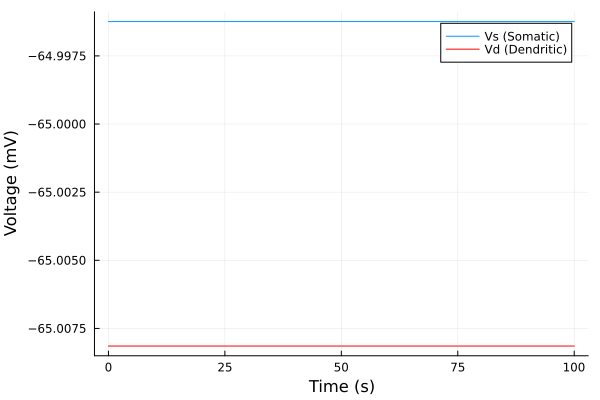

In [16]:
# 結果のプロット
using Plots
Vs_vals = [v[1] for v in voltages]  # 細胞体の膜電位の履歴
Vd_vals = [v[2] for v in voltages]  # 樹状突起の膜電位の履歴
plot(tspan, Vs_vals, label="Vs (Somatic)", xlabel="Time (s)", ylabel="Voltage (mV)", legend=:topright)
plot!(tspan, Vd_vals, label="Vd (Dendritic)", color=:red)